# Vaja: Preurejanje skripte

## Stara skripta

analyze-plc-data.py

In [ ]:
#%%
import pandas as pd
from dateutil.parser import parse as duparse
import plotly.graph_objects as go
import datetime
import os

#%%
input_file = "20200915 081812_10_2_6_26.csv"
resample = 60
base = os.path.splitext(input_file)[0]
convertedPath = f'{base}-converted.csv'

# clean csv file and convert it to clean form
if not os.path.exists(convertedPath):
    s = open(input_file).read()
    s = s.replace('"=""', '').replace('"', '')
    f = open(convertedPath, 'w')
    f.write(s)
    f.close()

#%%
df_log = pd.read_csv(convertedPath, delimiter=";", low_memory=False)

#convert to datetime
df_log["Time"] = pd.to_datetime(df_log["Time"], yearfirst=True)

#convert type column to category
df_log.Type = df_log.Type.astype("category")

#do some stats:
timespan = df_log.Time.max() - df_log.Time.min()

#make clone of column Time and set column Time as index
df_log["original Time"] = df_log["Time"]
df_log = df_log.set_index("Time")

#%%

comment = f'Observing time: {timespan}.'
print(comment)




df_log_rrep = df_log[df_log.Type.str.contains('LOADNG RREP', na=False)]


#%%
#reindex df

groups_rrep = df_log_rrep["Type"].resample(f"{resample}T", label='right', closed="right").count()

df_result = pd.DataFrame(groups_rrep)

#df_result.to_excel('df_result.xlsx')
#%%
chart = go.Figure()
chart.add_trace(go.Bar(x=df_result.index, y=df_result.Type, name="# of rrep", marker=dict(color="red")))

chart.update_traces(opacity=0.7)


chart.write_html(f'{base}_resampleTo{resample}min.html')

# %%

## Preurejena skripta

In [65]:
import os

import pandas as pd
import matplotlib.pyplot as plt 


class LogParser:
    def __init__(self, input_file_name):
        self.input_file_name = input_file_name
        self.data = self._clean_data(self._read_file())
        self.timespan =  self._get_timespan()
    
    def __str__(self):
        return f'Dataset: {self.input_file_name}\nSize: {self.data.shape}\nTimespan: {self.timespan}'

    def _read_file(self):
        df = pd.read_csv(self.input_file_name, delimiter=";", low_memory=False, na_values=['=""'])
        return df
    
    def _clean_data(self, df):
        # odstranimo posebne znake
        df = df.replace('="', '', regex=True)
        df = df.replace('"', '', regex=True)
        # uredimo stolpec Time
        df["Time"] = pd.to_datetime(df["Time"], format="%Y.%m.%d %H:%M:%S.%f")
        # convert Type column to category
        df['Type'] = df['Type'].astype("category")
        #make clone of column Time and set column Time as index
        df["Original_Time"] = df["Time"]
        df = df.set_index("Time")
        # izvozimo urejene podatke
        return df
        
    def _get_timespan(self):
        diff = self.data["Original_Time"].max() - self.data["Original_Time"].min()
        return diff
        
    def export_clean_data(self, export_format='csv'):
        converted_file_name = f'{os.path.splitext(self.input_file_name)[0]}-converted.{export_format}'
        '''Exports clean data to selected format (csv, json, xlsx)'''
        if export_format == 'csv':
            self.data.to_csv(converted_file_name)
        elif export_format == 'json':
            data_to_json = self.data.copy()
            data_to_json = data_to_json.reset_index()
            data_to_json.to_json(converted_file_name, orient='index')
        elif export_format == 'xlsx':
            self.data.to_excel(converted_file_name)
        else:
            raise ValueError("Parameter export_format should be one of: csv, json, xlsx ")
        
    def type_rrep_resample_count(self, resample=60):
        df_log_rrep = self.data[self.data['Type'].str.contains("LOADNG RREP", na=False)].copy()
        groups_rrep = df_log_rrep["Type"].resample(f"{resample}T", label="right", closed="right").count()
        return pd.DataFrame(groups_rrep)
    
    def plot_type_rrep_resample_count(self, resample=60):
        df_result = self.type_rrep_resample_count(resample)
        fig, ax = plt.subplots()
        df_result.plot(kind='bar', ax=ax, legend=False, color='red')
        ax.set_xlabel("Time") 
        ax.set_ylabel("# of rrep") 
        ax.set_title("rrep results")
        plt.show()

#### Namestimo openpyxl

In [19]:
!pip install openpyxl

     |████████████████████████████████| 242 kB 1.6 MB/s eta 0:00:01
  Created wheel for et-xmlfile: filename=et_xmlfile-1.0.1-py3-none-any.whl size=8917 sha256=d24e26ac88c76f2a9488e2a12cbd0bf3a812a61837004da6d78878bf8ebe4cc5
  Stored in directory: /home/jovyan/.cache/pip/wheels/6e/df/38/abda47b884e3e25f9f9b6430e5ce44c47670758a50c0c51759
Successfully built et-xmlfile


### Uporaba

In [66]:
input_file = "data/20200915 081812_10_2_6_26.csv"
parser = LogParser(input_file)

In [67]:
print(parser)

Dataset: data/20200915 081812_10_2_6_26.csv
Size: (96883, 16)
Timespan: 0 days 17:44:36.643000


In [68]:
# dostop do podatkov
df = parser.data
df.head()

,Num,Source,Destination,Originator,Target,Type,Modulation,LQI,RSSI,Counter,ToneMap,Length,Info,Payload,TMR LQI,Original_Time
Time,,,,,,,,,,,,,,,,
2020-09-14 14:29:05.154,1.0,0000,0002,0000,0002,Encrypted,D8PSK,125.0,125.0,811614.0,63.0,2 (15),"SN=AF, SC=1, LSF=1, FC=00000C625E, FCS=7850",00C78963831EB734DFB3F879D776AA,NaN,2020-09-14 14:29:05.154
2020-09-14 14:29:05.154,NaN,0000,0002,0000,0002,LOADNG PREQ,NaN,NaN,NaN,NaN,NaN,(11),"SN=AF, SC=0, LSF=1",4001FC00020000F0572828,NaN,2020-09-14 14:29:05.154
2020-09-14 14:29:05.154,2.0,NaN,NaN,NaN,NaN,ACK,NaN,NaN,125.0,NaN,NaN,NaN,FCS = 7850,NaN,NaN,2020-09-14 14:29:05.154
2020-09-14 14:31:08.717,3.0,0000,0002,0000,0002,Encrypted,D8PSK,125.0,125.0,811615.0,63.0,2 (15),"SN=B0, SC=1, LSF=1, FC=00000C625F, FCS=C4E3",2B9E7F2AA3FE06302163E253D07D2B,NaN,2020-09-14 14:31:08.717
2020-09-14 14:31:08.717,NaN,0000,0002,0000,0002,LOADNG PREQ,NaN,NaN,NaN,NaN,NaN,(11),"SN=B0, SC=0, LSF=1",4001FC00020000F0A4F6BC,NaN,2020-09-14 14:31:08.717


In [60]:
# izvoz čistih podatkov v različne tipe

In [63]:
#parser.export_clean_data(export_format='lalalal') # primer narobe formata

In [62]:
parser.export_clean_data(export_format='json')

In [17]:
parser.export_clean_data(export_format='json')

In [20]:
parser.export_clean_data(export_format='xlsx')

In [69]:
# count rrep
parser.type_rrep_resample_count()

,Type
Time,
2020-09-14 16:00:00,1
2020-09-14 17:00:00,0
2020-09-14 18:00:00,2
2020-09-14 19:00:00,2
2020-09-14 20:00:00,0
2020-09-14 21:00:00,3
2020-09-14 22:00:00,3
2020-09-14 23:00:00,4
2020-09-15 00:00:00,1


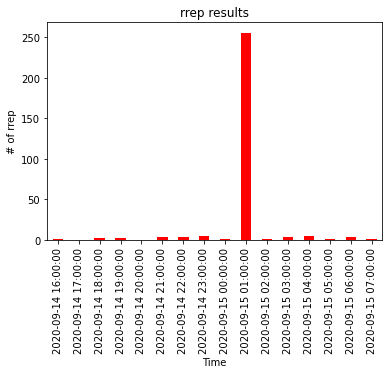

In [70]:
parser.plot_type_rrep_resample_count()